## Evaluate the baseline correction performance of all methods and models available to us

We aim to gather the metrics of all methods on different generated datasets and make them comparable. This combines the other comparison scripts into a cohesive whole

In [1]:
from Scripts.essentials import *
from Scripts.BaselineRemovalCopy import *
from Scripts.BubbleFillCopy import *

Available computational components
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6519038798066946383
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5835325440
locality {
  bus_id: 1
  links {
  }
}
incarnation: 414985596889797051
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 OEM, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


# Load the models

In [2]:
ensemble_model = make_ensemble()
ensemble_model.load_weights(filepath= "Models/ensembleModelRes.h5")

standard_model = make_standard()
standard_model.load_weights(filepath = "Models/standardModel.h5")

# Cascaded model
cascade = tf.keras.models.load_model("Models/unet_three.23-64.96.h5")

In [3]:
standard_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 custom_pad_13 (CustomPad)      (None, None, 1)      0           ['input_2[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, None, 20)     2580        ['custom_pad_13[0][0]']          
                                                                                                  
 batch_normalization_6 (BatchNo  (None, None, 20)    80          ['conv1d_4[0][0]']               
 rmalization)                                                                               

In [4]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 custom_pad (CustomPad)         (None, None, 1)      0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, None, 10)     1290        ['custom_pad[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, None, 10)    40          ['conv1d[0][0]']                 
 alization)                                                                                   

In [10]:
d_path = "data/Generated_data/"
datasets = [#(d_path+"X_1024_16_100.npy", d_path+"y_baseline_1024_16_100.npy"),
           #(d_path+"X_1024_200_256.npy", d_path+"y_baseline_1024_200_256.npy"),
            #(d_path+"X_1024_256_300.npy", d_path+"y_baseline_1024_256_300.npy"),
           (d_path+"X_1024_10_300.npy", d_path+"y_baseline_1024_10_300.npy"),
           ]

metrics_dict = {}
full_metrics_dict = {}
for data in datasets:

    # Load the dataset we want to evaluate
    X = np.load(data[0])
    target = np.load(data[1])

    ## DL-predictions ##
    
    # Ensemble model predictions
    ensemble_preds = ensemble_model.predict(X, verbose = 0)
    # Get the baseline
    ensemble_preds = ensemble_preds[0]
    
    # Standard model
    standard_preds = standard_model.predict(X, verbose = 0)
    # Get the baseline
    standard_preds = standard_preds[0]
    
    # Cascaded preds, multiply X by 1000 to set the required input shape
    cascaded_preds = cascade.predict(X * 1000, verbose = 0)
    # Get baselines, by subtracting the baseline corrected spectrum
    cascaded_preds = (X*1000) - cascaded_preds[0]
    # Divide by 1000 to return to the normalized scope
    cascaded_preds = cascaded_preds / 1000
    
    # airPLS
    
    airPLS_preds = []

    for x in X:
        airPLS_preds.append(airPLS(np.squeeze(x)))
        
    # ModPoly
    mod_preds = []
    DEGREE = 5
    for x in X:
        
        baselineObj = BaselineRemoval_source(np.squeeze(x))
        pred = baselineObj.ModPoly(DEGREE) 
        # ALgorithm gives corrected spectrum, subtract from input to get baseline
        mod_preds.append(np.squeeze(x) - pred)
    
    #ImodPoly:
    imod_preds = []
    for x in X:
        
        baselineObj = BaselineRemoval_source(np.squeeze(x))
        pred = baselineObj.IModPoly(DEGREE) 
        # ALgorithm gives corrected spectrum, subtract from input to get baseline
        imod_preds.append(np.squeeze(x) - pred)
        
        
    # bubblefill:
    bubble_preds = []
    min_bubble_widths = 75
    for x in X:
        # Algorithm gives corrected spectrum and baseline itself, baseline is index 1
        pred = bubblefill(np.squeeze(x), min_bubble_widths = min_bubble_widths)[1] 
        bubble_preds.append(pred)


    method_preds = [ensemble_preds, standard_preds,
                    cascaded_preds, bubble_preds,
                    airPLS_preds, imod_preds, mod_preds]
    
    method_names = ["Ensemble", "Standard",
                    "Kazemzadeh et al.", "Bubble fill",
                    "airPLS", "IModPoly", "ModPoly"]

    # Save the figures in a unique folder for potential use later
    path = "Figures/"+ data[1].split("/")[-1]
    if not os.path.exists(path):
        os.mkdir(path)
        # Gather the metrics
        
    metrics_dict[data[0]] = {}
    full_metrics_dict[data[0]] = {}
    print("####", data[0], "####")
    for preds, name in zip(method_preds, method_names):
        print(name)
        RMSE_metrics = []
        MaxError_metrics = []
        for spec, p in zip(target, np.squeeze(preds)):
            RMSE_metrics.append(root_mean_squared_error(p, spec)) # I defined the metrics with true, pred order...
            MaxError_metrics.append(metrics.max_error(spec, p))
            
        print("\tRMSE:",
              "\n\t\tMean:", np.round(np.mean(RMSE_metrics), 2),
              "\n\t\tMedian:", np.round(np.median(RMSE_metrics), 2),
              "\n\t\tVariance:", np.round(np.var(RMSE_metrics), 2))
        

    
        print("\tMax error:",
              "\n\t\tMean:", np.round(np.mean(MaxError_metrics), 2),
              "\n\t\tMedian:", np.round(np.median(MaxError_metrics), 2),
              "\n\t\tVariance:", np.round(np.var(MaxError_metrics), 2))

        metrics_dict[data[0]][name] = [np.mean(RMSE_metrics), np.median(RMSE_metrics), np.var(RMSE_metrics),
                                       np.mean(MaxError_metrics), np.median(MaxError_metrics),
                                       np.var(MaxError_metrics)]

        full_metrics_dict[data[0]][name] = [np.array(RMSE_metrics), np.array(MaxError_metrics)]

WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max

In [11]:
header = ["RMSE:mean", "RMSE:median", "RMSE:variance", "MaxError:mean", "MaxError:median", "MaxError:variance"]

with pd.ExcelWriter('Results/BaselineComparisons.xlsx') as writer:
    for key in metrics_dict.keys():

        df = pd.DataFrame.from_dict(metrics_dict[key],
                                        columns = header,
                                        orient = "index")
        filename = key.split("/")[1] + key.split("/")[2]
        df = df.round(decimals = 3)
        df.to_excel(writer, sheet_name=filename)
        
        print()
        df = df.style.format(decimal='.', thousands='.', precision=2)
        print(df.to_latex())


\begin{tabular}{lrrrrrr}
 & RMSE:mean & RMSE:median & RMSE:variance & MaxError:mean & MaxError:median & MaxError:variance \\
Ensemble & 0.03 & 0.02 & 0.00 & 0.07 & 0.06 & 0.00 \\
Standard & 0.02 & 0.02 & 0.00 & 0.06 & 0.05 & 0.00 \\
Kazemzadeh et al. & 0.05 & 0.04 & 0.00 & 0.37 & 0.30 & 0.05 \\
Bubble fill & 0.15 & 0.15 & 0.01 & 0.24 & 0.26 & 0.02 \\
airPLS & 0.19 & 0.20 & 0.01 & 0.25 & 0.26 & 0.02 \\
IModPoly & 0.04 & 0.04 & 0.00 & 0.11 & 0.08 & 0.01 \\
ModPoly & 0.07 & 0.06 & 0.00 & 0.14 & 0.12 & 0.01 \\
\end{tabular}



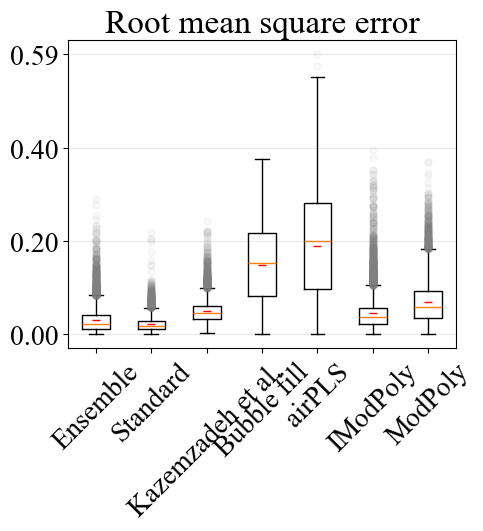

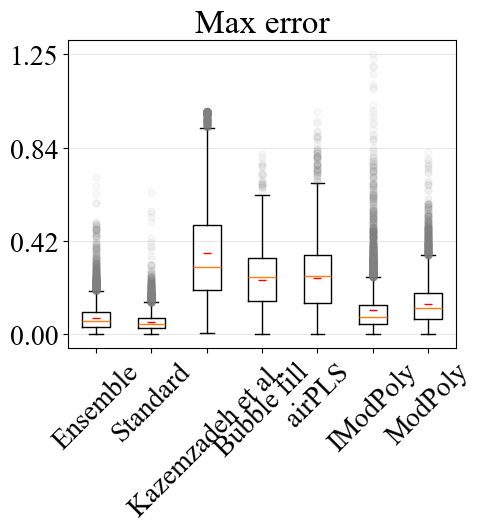

In [12]:
method_names = ["Ensemble", "Standard",
                    "Bubble fill", "Kazemzadeh et al.",
                    "airPLS", "IModPoly", "ModPoly"]

plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"] = "Times New Roman"
dimension = (5, 4)
num_ticks = 4
for key in full_metrics_dict.keys():

    key2 = list(full_metrics_dict[key].keys())


    # RMSE metrics
    flier_props = dict(marker='o', markerfacecolor='gray', alpha = 0.05, markersize=5,
                  linestyle='none', markeredgecolor="gray")
    mean_props = {"marker": "_", 'markerfacecolor': "Red", 'markeredgecolor': "Red"}
    
    model_metrics = [full_metrics_dict[key][k][0] for k in key2]
    fig, ax = plt.subplots(figsize = dimension)
    ax.boxplot(model_metrics,
                  labels = key2,
                  showmeans=True, 
                  flierprops = flier_props,
                  meanprops= mean_props,
                 )

    
    ax.set_title("Root mean square error")
    max_ = np.max([full_metrics_dict[key][k][0] for k in key2])
    ticks = np.linspace(0, max_, num_ticks)
    ax.set_yticks(ticks)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
    ax.set_xticklabels(key2, rotation = 45)
    plt.savefig("Figures/Metrics/B_RMSE.png", format="png",
                bbox_inches='tight',
                dpi = 1000,
                transparent = True,
                pad_inches=0.5)
    plt.show()
    
    
    # Max error metrics
    model_metrics = [full_metrics_dict[key][k][1] for k in key2]
    fig, ax = plt.subplots(figsize = dimension)
    ax.boxplot(model_metrics,
                  labels = key2,
                 showmeans=True,
                  flierprops = flier_props,
                  meanprops= mean_props,
                 #showfliers=False,
                 )
    ax.set_title("Max error")
    max_ = np.max([full_metrics_dict[key][k][1] for k in key2])
    ticks = np.linspace(0, max_, num_ticks)
    ax.set_yticks(ticks)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
    ax.set_xticklabels(key2, rotation = 45)
    plt.savefig("Figures/Metrics/B_MaxError.png", format="png",
                bbox_inches='tight',
                dpi = 1000,
                transparent = True,
                pad_inches=0.5)
    plt.show()